# Learning t-test, p-value, pearson correlation

<b> I'll go over these subjects with a simple-and-neat exercise. </b>:
1. Given a dataset, I'll calculate a t-test between each 2 columns and then will plot a heatmap. 
2. I'll plot binary heatmaps using distinct p-values as the threshold. 
3. I'll write a function that provided a list of columns and a target column, calculates the Pearson Correlation between a linear combination of the columns list -using a provided list of weights-, and the target one. 
4. Using the previous function, I'll search among some random combinations for the one with the highest correlation.

# Loading the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind
from matplotlib import pyplot as plt
from itertools import product
import random

<b> I'll use for the task a small dataset, one of the standard basic ones in learning machine learning: houses prices.

In [2]:
df = pd.read_csv("houses.csv")
df = df.select_dtypes(["int64", "float64"])
df.shape

(1460, 38)

# 1. A heatmap with the t-test for every columns pair.

#### Using scipy.stats.ttest_ind I calculate the t-statistics and the p-values. And then I build a DF with those pairs.

In [3]:
df_stats = pd.DataFrame(columns=df.columns, index=df.columns)
for tup in product(df.columns,repeat=2):
    df_stats.loc[tup[0],tup[1]] = ttest_ind(df[tup[0]].dropna(), df[tup[1]].dropna())

#### I plot the heatmaps using the calculated DFs

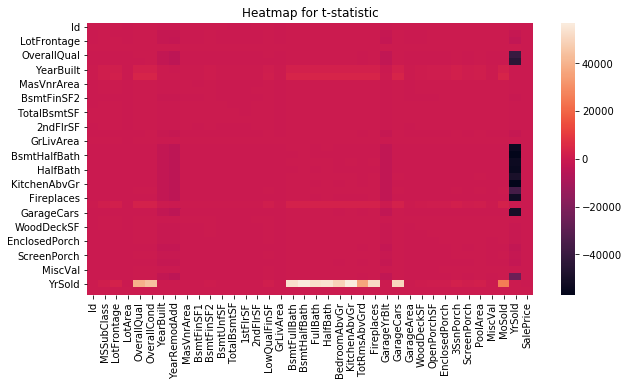

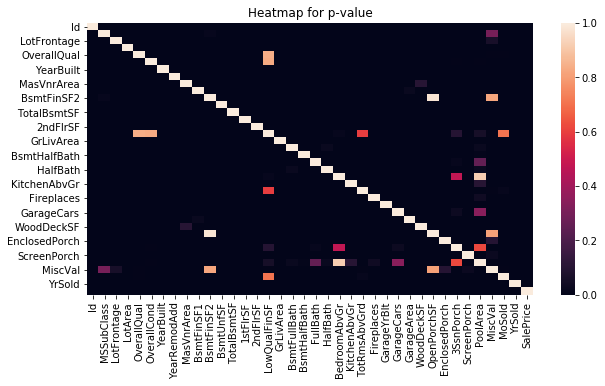

In [4]:
plt.figure(figsize=(10,5))
plt.title('Heatmap for t-statistic')
sns.heatmap(df_stats.applymap(lambda x:x[0]))
plt.show()

plt.figure(figsize=(10,5))
plt.title('Heatmap for p-value')
sns.heatmap(df_stats.applymap(lambda x:x[1]))
plt.show()

#### Optionally, we could for example output the results.

In [5]:
np.savetxt('t-statistic.txt', df_stats.applymap(lambda x:x[0]).values)
np.savetxt('p-value.txt', df_stats.applymap(lambda x:x[1]).values)

<b> I removed the null values instead of removing all the rows with some NaN. Otherwise, it would have mean removing most of the data:

In [6]:
round(len(df.dropna())/len(df),2)

0.77

# 2. A binary heatmap with the p-value as threshold.

<b> I'll use 0.05, 0.1, 0.2 as the p-values

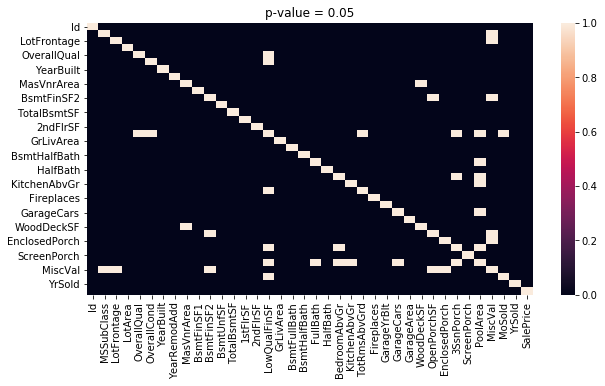

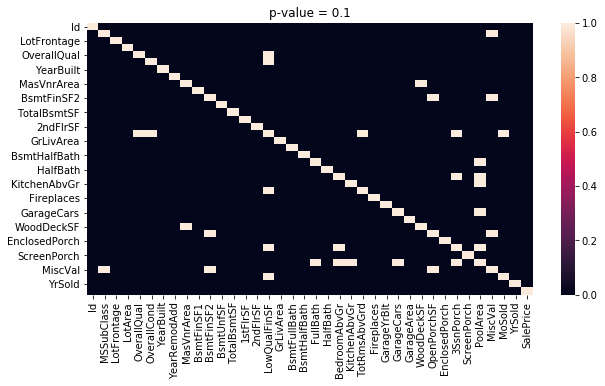

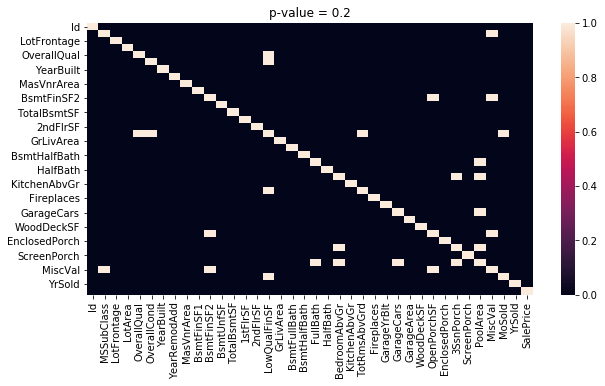

In [7]:
#We define a new Dataframe where each cell corresponds to a p-value from before.
#For every threshold, we set each cell to False(0) if the corresponding p-value is smaller than the given threshold.
#And True(1) otherwise.
for p_value in [0.05, 0.1, 0.2]:
    plt.figure(figsize=(10,5))
    df_p_val = df_stats.applymap(lambda x:x[1])
    sns.heatmap(df_p_val.apply(lambda x:x>p_value))
    plt.title('p-value = '+str(p_value))
    plt.show()

# 3.  A Pearson correlation function with linear combinations.

<b> Given columns (i, j), weights (Wi, Wj) and target column (k) it  returns the pearson correlation between (i * Wi + j * Wj) and k.

In [8]:
def pearson_for_linear_combination (data, columns_index, weights, target_column_index):
    
    '''
    Returns the pearson correlation between a column and a linear combination of columns.
    
    Parameters:
        data: The Pandas dataframe to take the values from.
        columns_index: a list of indices of columns from the dataframe to be multiplied by the provided weights.
        weights: a list of weights to be multiplied by the column corresponding to the provided indices.
        target_column_index: the index of the additional column to calculate the pearson correlation.

    Returns:
        the pearson correlation between:
        1. data[target_column_index], and
        2. the sum of data[columns_index[i]*weights[i]] for every i in 0 ... len(columns_index), which has to be equal to len(weights).  
    '''
    
    assert len(columns_index) == len(weights)
    
    #When doing the linear combination, NaN values are ignored. That is, they are taken as 0.
    #Therefore, even though Pandas corr() function automatically removes rows with some NaN value,
    #we need to remove in advance the rows with a NaN value for one of the columns_index.
    
    clean_data = data.dropna(subset=df.columns[columns_index])
    
    columns_linear_comb = (clean_data.iloc[:,columns_index] * weights).sum(axis=1)
    target_column = clean_data.iloc[:, target_column_index]  
    
    ROUND_PLACES = 4
    return round(columns_linear_comb.corr(target_column),ROUND_PLACES)

In [9]:
#A a sanity check with some values.
pearson_for_linear_combination(df, [0,1,6], [2,3,7], 9)

0.0452

# 4. Searching for the highest correlation using random linear combinations.

In [10]:
#Returnt 3 random column indices and 2 random weights
def get_random_3_cols_and_2_weights():
    cols = random.sample(range(len(df.columns)), k=3)
    weights = np.random.randint(1, 5, size=2)
    return cols, weights

In [11]:
def get_max_correlation(samples):
    max_corr = 0
    max_corr_columns = None
    max_corr_weights = None
    for i in range(samples):
        cols, weights = get_random_3_cols_and_2_weights()
        corr = pearson_for_linear_combination(df, cols[:2], weights, cols[2])
        if abs(corr) > max_corr:
            max_corr = corr
            max_corr_columns = cols
            max_corr_weights = weights
    return max_corr, max_corr_columns, max_corr_weights

In [12]:
def get_cols_descriptions():
    cols_descriptions = dict()
    f = open("data_description.txt", "r")
    lines = f.readlines()
    for line in lines:
        if line[0] != ' ' and line[0]!='\n' and line[0]!='\t':
            sep = line.find(":")
            col = line[:sep]
            description = line[sep+2:].strip()
            cols_descriptions[col] = description
    return cols_descriptions

In [13]:
cols_descriptions = get_cols_descriptions()

In [14]:
def get_col_name(col_index):
    name = df.columns[col_index]
    return cols_descriptions[name]

In [15]:
corr, columns, weights = get_max_correlation(1000)

In [16]:
first_term = str(weights[0]) + " * " + get_col_name(columns[0]) 
second_term = str(weights[1]) + " * " + get_col_name(columns[1])
best_linear_combination = first_term + " + " + second_term

In [17]:
print("The correlation with the highest absolute value is:", "\n")
print(best_linear_combination, "\n")
print("Which gives an absolute correlation value of", corr)

The correlation with the highest absolute value is: 

2 * Year garage was built + 1 * First Floor square feet 

Which gives an absolute correlation value of 0.8326
